In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torch.optim as optim
import torch
import os
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import psutil  # For monitoring memory usage
from torch.nn.functional import cosine_similarity
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from tqdm import tqdm
from torchsummary import summary
import pandas as pd

sys.path.append(os.path.abspath('unet'))
from unet import Unet
print("Switched back to:", os.getcwd())


from transformers import SpeechT5HifiGan


Switched back to: /home/nico/Desktop/NeuralSVB


In [3]:
import transformers
from transformers import SpeechT5Processor

In [4]:
# Ensure device is set
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def parse_wav_files(base_dir):
    """
    Parse all .wav files and organize them into a dictionary.

    Args:
        base_dir (str): The base directory containing singers' folders.

    Returns:
        dict: A dictionary with keys as "{song_name + technique}" and values as "{singer, technique, file_path (list)}".
    """
    singers_data = {
        "ZH-Alto-1": "Singer_Alto",
        "ZH-Tenor-1": "Singer_Tenor"
    }

    wav_dict = {}

    for singer_folder, singer_name in singers_data.items():
        singer_path = os.path.join(base_dir, "Chinese", singer_folder)

        # Traverse through techniques
        for technique in os.listdir(singer_path):
            technique_path = os.path.join(singer_path, technique)

            if not os.path.isdir(technique_path):
                continue

            # Traverse through song names
            for song_name in os.listdir(technique_path):
                song_path = os.path.join(technique_path, song_name)

                if not os.path.isdir(song_path):
                    continue

                # Traverse through groups
                for group in os.listdir(song_path):
                    group_path = os.path.join(song_path, group)

                    if not os.path.isdir(group_path):
                        continue

                    # Traverse .wav files in the group
                    for file_name in os.listdir(group_path):
                        if file_name.endswith(".wav"):
                            file_path = os.path.join(group_path, file_name)
                            key = f"{song_name}_{technique}"

                            # Add to dictionary
                            if key not in wav_dict:
                                wav_dict[key] = {
                                    "singer": singer_name,
                                    "technique": technique,
                                    "file_path": []
                                }

                            # Append file path to the list
                            wav_dict[key]["file_path"].append(file_path)

    return wav_dict

#################
base_directory = "."  # Replace with the actual path
wav_dict = parse_wav_files(base_directory)

# Remove file paths with "Paired_Speech_Group"
for key, value in wav_dict.items():
    value['file_path'] = [
        path for path in value['file_path']
        if "Paired_Speech_Group" not in path
    ]

# Display the results
for key, value in wav_dict.items():
    print(f"Key: {key}")
    print(f"Value: {value}")
#################

Key: 匆匆那年_Breathy
Value: {'singer': 'Singer_Alto', 'technique': 'Breathy', 'file_path': ['./Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0004.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0009.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0001.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0011.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0007.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0002.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0000.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0006.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0003.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0010.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0008.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0005.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Control_Group/0012.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Breathy_Group/0004.wav', './Chinese/ZH-Alto-1/Breathy/匆匆那年/Breathy_Group/0009.wav', './Chinese/ZH-Alto-1/Breat

In [6]:
# Preprocess each audio file in wav_dict
preprocessed_wav_dict = {}
for key, value in wav_dict.items():
    preprocessed_wav_dict[key] = {
        "singer": value["singer"],
        "technique": value["technique"],
        "file_path": value["file_path"]
    }

# Display the results
for key, value in preprocessed_wav_dict.items():
    print(f"Key: {key}")
    print(f"Singer: {value['singer']}")
    print(f"Technique: {value['technique']}")

Key: 匆匆那年_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 慢慢喜欢你_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 失落沙洲_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 水星记_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 成都_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 说谎_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 江南_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 给电影人的情书_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 越过山丘_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 奇妙能力歌_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 可乐_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 走马_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 云烟成雨_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 不再见_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 最长的电影_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 默_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 知足_Breathy
Singer: Singer_Alto
Technique: Breathy
Key: 温柔_Breathy
Singer: Singer_Alto
Techni

./Chinese/ZH-Alto-1/Breathy/不再见/Control_Group/0004.wav


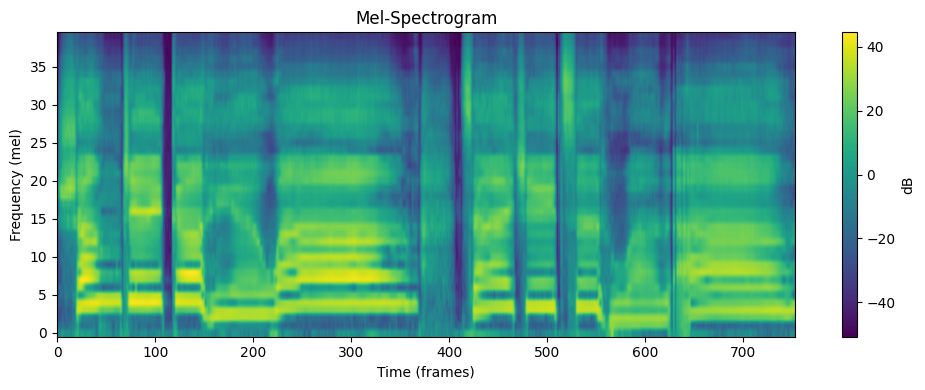

tensor([[[ -8.0051,  -5.1345,  -5.8188,  ...,  -6.5240,  -9.7418,   2.1251],
         [-14.3457, -16.0752, -17.1855,  ..., -17.9367, -19.2410,   3.5820],
         [-21.1597, -25.3494, -27.8659,  ...,  18.8361,  16.6942,  15.5793],
         ...,
         [-45.6689, -43.9821, -36.8231,  ..., -24.0181, -23.9790, -24.1910],
         [-47.0503, -45.4317, -39.0722,  ..., -29.9842, -30.3574, -31.7597],
         [-48.4041, -45.9342, -41.8607,  ..., -30.6471, -30.6339, -30.9899]]])


In [7]:
import torchaudio.transforms as T

# Create MelSpectrogram transform
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=48000,
    n_fft=2048,
    hop_length=512,
    n_mels=40
)


def compute_mel_spectrogram(
    audio_path,
    sample_rate=48000,
    n_fft=2048,
    hop_length=512,
    n_mels=128,
    to_db=True,
    show_plot=False
):
    """
    Compute the mel-spectrogram of an audio file.

    Parameters:
        audio_path (str): Path to the audio file.
        sample_rate (int): Desired sample rate of the audio.
        n_fft (int): Number of FFT points.
        hop_length (int): Number of samples between successive frames.
        n_mels (int): Number of mel filter banks.
        to_db (bool): Whether to convert the spectrogram to decibel scale.

    Returns:
        torch.Tensor: Mel-spectrogram (in dB if to_db is True).
    """
    # Load audio file
    waveform, orig_sample_rate = torchaudio.load(audio_path)

    # Resample if necessary
    if orig_sample_rate != sample_rate:
        resampler = T.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)
        waveform = resampler(waveform)

    # Compute the mel-spectrogram
    mel_spec = mel_spectrogram_transform(waveform)

    # Convert to dB if required
    if to_db:
        db_transform = T.AmplitudeToDB(stype='power')
        mel_spec = db_transform(mel_spec)

    # Visualize the mel-spectrogram
    if show_plot:
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='dB')
        plt.title('Mel-Spectrogram')
        plt.xlabel('Time (frames)')
        plt.ylabel('Frequency (mel)')
        plt.tight_layout()
        plt.show()

    return mel_spec

temp_filepath = wav_dict['不再见_Breathy']['file_path'][0]
print(temp_filepath)
mel_spec = compute_mel_spectrogram(temp_filepath, show_plot=True)
print(mel_spec)

In [8]:
import numpy as np

# List of techniques
techniques = ["Breathy", "Glissando", "Mixed Voice and Falsetto", "Pharyngeal", "Vibrato"]

# One-hot encoding mapping
technique_to_onehot = {tech: np.eye(len(techniques))[i].tolist() for i, tech in enumerate(techniques)}

# Example usage
print(technique_to_onehot["Breathy"])  # Output: [1, 0, 0, 0, 0]

[1.0, 0.0, 0.0, 0.0, 0.0]


In [9]:
def compute_global_min_max(data_dict, sample_rate=48000):
    """
    Computes the global minimum and maximum of mel-spectrograms for all files in the dictionary.

    Args:
        data_dict (dict): Dictionary containing file paths for all techniques.
        sample_rate (int): Sample rate for loading audio.

    Returns:
        tuple: (mel_min, mel_max) across all mel-spectrograms.
    """
    global_min = float('inf')
    global_max = float('-inf')

    counter = 0

    for key, value in data_dict.items():
        file_paths = value["file_path"]

        for file_path in file_paths:

            if counter % 250 == 0:
                print(counter)

            # Compute mel-spectrogram for each file
            mel_spectrogram = compute_mel_spectrogram(file_path, sample_rate=sample_rate)

            # Update global min and max
            file_min = mel_spectrogram.min().item()
            file_max = mel_spectrogram.max().item()

            global_min = min(global_min, file_min)
            global_max = max(global_max, file_max)

            # Debugging/logging
            counter = counter + 1
            # print(f"[DEBUG] File: {file_path}, Min: {file_min}, Max: {file_max}")

    return global_min, global_max

# Compute global min and max
global_mel_min, global_mel_max = compute_global_min_max(wav_dict)
print(f"Global Mel-Spectrogram Min: {global_mel_min}, Max: {global_mel_max}")

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
Global Mel-Spectrogram Min: -100.0, Max: 55.02522277832031


In [10]:
def normalize_mel(mel, global_mel_min, global_mel_max):
    """
    Normalize the mel-spectrogram to range [0, 1].
    Args:
        mel (np.ndarray or torch.Tensor): Input mel-spectrogram.
    Returns:
        torch.Tensor: Normalized mel-spectrogram.
    """
    return (mel - global_mel_min) / (global_mel_max - global_mel_min + 1e-8)

In [11]:
# total 4080

class VocalTechniqueDataset(Dataset):
    def __init__(self, data_dict, sample_rate=48000, fixed_timesteps=196, step_size=10, transform=None):
        """
        Initializes the dataset.

        Args:
            data_dict (dict): Dictionary containing file paths for all techniques.
            sample_rate (int): Sample rate for loading audio.
            fixed_timesteps (int): Fixed number of timesteps for all samples.
            step_size (int): Step size for sequential sampling.
            transform (callable, optional): Transformation to apply to audio.
        """
        self.data_pairs = []
        self.sample_rate = sample_rate
        self.fixed_timesteps = fixed_timesteps
        self.step_size = step_size
        self.transform = transform

        # Map techniques to one-hot encodings
        techniques = ["Breathy", "Glissando", "Mixed_Voice_and_Falsetto", "Pharyngeal", "Vibrato"]
        self.technique_to_onehot = {tech: np.eye(len(techniques))[i].tolist() for i, tech in enumerate(techniques)}

        # Pair files by matching filenames and calculate global min/max
        for key, value in data_dict.items():
            control_files = [path for path in value["file_path"] if "Control_Group" in path]
            technique_files = [path for path in value["file_path"] if "Group" in path and "Control_Group" not in path]

            control_files_map = {os.path.basename(f): f for f in control_files}
            for technique_path in technique_files:
                filename = os.path.basename(technique_path)
                if filename in control_files_map:
                    # Pair with technique label
                    pair = (control_files_map[filename], technique_path, value["technique"])
                    self.data_pairs.append(pair)

                    # print(f"paired{pair[0]} -> {pair[1]}")



    def __len__(self):
        return len(self.data_pairs)

    def sample_fixed_window(self, mel_spec):
        """
        Adjusts the timesteps of the mel-spectrogram to 400:
        - If timesteps < 400, pads with zeros to 400.
        - If timesteps > 400, truncates to 400 and pads remaining slots with zeros.

        Args:
            mel_spec (torch.Tensor): Mel-spectrogram of shape [n_mels, timesteps].

        Returns:
            torch.Tensor: Mel-spectrogram adjusted to have 400 timesteps.
        """
        n_mels, timesteps = mel_spec.shape
        target_timesteps = 400

        if timesteps < target_timesteps:
            # Pad with zeros to make timesteps = 400
            padding = target_timesteps - timesteps
            mel_spec = torch.nn.functional.pad(mel_spec, (0, padding))
        elif timesteps > target_timesteps:
            # Truncate to the first 400 timesteps
            mel_spec = mel_spec[:, :target_timesteps]
            # Pad with zeros to maintain consistent shape
            padding = target_timesteps - mel_spec.shape[1]
            mel_spec = torch.nn.functional.pad(mel_spec, (0, padding))

        return mel_spec

    def __getitem__(self, idx):
        # Retrieve paths and technique from the data_pairs
        control_path, technique_path, technique = self.data_pairs[idx]

        # Compute mel-spectrograms
        control_mel = compute_mel_spectrogram(control_path, sample_rate=self.sample_rate)
        technique_mel = compute_mel_spectrogram(technique_path, sample_rate=self.sample_rate)

        # Remove the extra batch dimension if present
        control_mel = control_mel.squeeze(0)  # Shape becomes [n_mels, timesteps]
        technique_mel = technique_mel.squeeze(0)  # Shape becomes [n_mels, timesteps]

        # Normalize mel-spectrograms
        control_mel = normalize_mel(control_mel, global_mel_min, global_mel_max)
        technique_mel = normalize_mel(technique_mel, global_mel_min, global_mel_max)

        # Use sample_fixed_window to adjust timesteps to the target size
        control_mel = self.sample_fixed_window(control_mel)  # Returns a list of windows
        technique_mel = self.sample_fixed_window(technique_mel)  # Returns a list of windows

        # Add a channel dimension
        control_mel = control_mel.unsqueeze(1)  # Shape becomes [num_windows, 1, n_mels, fixed_timesteps]
        technique_mel = technique_mel.unsqueeze(1)  # Shape becomes [num_windows, 1, n_mels, fixed_timesteps]

        # Get one-hot encoding for the technique
        technique_onehot = self.technique_to_onehot[technique]
        technique_onehot = torch.tensor(technique_onehot, dtype=torch.float32)

        # Return a dictionary
        return {
            "control_mel": control_mel,
            "technique_mel": technique_mel,
            "technique_onehot": technique_onehot
        }


In [12]:
# Create the dataset and dataloader
dataset = VocalTechniqueDataset(wav_dict)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

counter = 0
for batch in dataloader:

    if counter == 10:
        break

    inputs = batch["control_mel"]
    targets = batch["technique_mel"]
    technique_embeddings = batch["technique_onehot"]

    print(f"Inputs type: {type(inputs)}, shape: {inputs.shape}")
    print(f"Targets type: {type(targets)}, shape: {targets.shape}")
    #torch size [16,1,40,400] 16 samples in each batch, 1 single audio channal, 40 mels, 400 timesteps
    #each column in the mel spectrogram represents the energy in 40 frequency bands at a particular time step
    print(f"Technique Embeddings type: {type(technique_embeddings)}, shape: {technique_embeddings.shape}, value: {technique_embeddings}")
    #torch size [16,5] 16 samples, 5 techniques

    counter = counter + 1

Inputs type: <class 'torch.Tensor'>, shape: torch.Size([16, 40, 1, 400])
Targets type: <class 'torch.Tensor'>, shape: torch.Size([16, 40, 1, 400])
Technique Embeddings type: <class 'torch.Tensor'>, shape: torch.Size([16, 5]), value: tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])
Inputs type: <class 'torch.Tensor'>, shape: torch.Size([16, 40, 1, 400])
Targets type: <class 'torch.Tensor'>, shape: torch.Size([16, 40, 1, 400])
Technique Embeddings type: <class 'torch.Tensor'>, shape: torch.Size([16, 5]), value: tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0.

In [13]:
sys.path.append(os.path.abspath('unet'))
from voice_encoder import VoiceEncoder
print("Switched back to:", os.getcwd())


#initialize the voice encoder
voice_encoder = VoiceEncoder(weights_fpath='unet/pretrained.pt')
voice_encoder.eval()

Switched back to: /home/nico/Desktop/NeuralSVB
Loaded the voice encoder model on cuda in 0.07 seconds.


/home/nico/Desktop/NeuralSVB/unet/voice_encoder.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_fpath, map_location="cpu")


VoiceEncoder(
  (lstm): LSTM(40, 256, num_layers=3, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (relu): ReLU()
)

In [14]:

for batch in dataloader:
    inputs = batch["control_mel"].to(device)
    targets = batch["technique_mel"].to(device)

    # Reshape the input tensor to match the expected input shape for the LSTM
    inputs = inputs.view(inputs.size(0), -1, 40)  # Reshape to [batch_size, sequence_length, input_size]
    targets = targets.view(targets.size(0), -1, 40)  # Reshape to [batch_size, sequence_length, input_size]
    device = next(voice_encoder.parameters()).device
    inputs = inputs.to(device)
    targets = targets.to(device)


    inputs_output = voice_encoder(inputs)
    targets_output = voice_encoder(targets)

    print(inputs_output.shape)
    print(targets_output.shape)
    print(inputs_output)

    break #印一次

    # Continue with training or evaluation logic
    # ...

torch.Size([16, 256])
torch.Size([16, 256])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0041, 0.0056, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0047, 0.0009, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0174, 0.0093, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0258, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0077, 0.0080, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0267, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<DivBackward0>)
